# **🧠 TL-S-CycleGAN (ResNet-50 Based Discriminator)**

## Import Required Libraries
We start by importing the essential PyTorch libraries, dataset utilities, and image processing tools needed for building and testing our CycleGAN variant with a ResNet-50 based discriminator.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import itertools
from torch.autograd import Variable

## Mount Google Drive
Since our datasets and pre-trained models are stored in Google Drive, we mount it here to access files directly within Colab.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define Data Transformations
We specify how our test images should be preprocessed before being passed to the model — converting them to tensors and normalizing pixel values to the range [-1, 1].


In [ ]:
# Load Data
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Load Test Dataset
We load the test dataset from Google Drive using `ImageFolder`, apply our transformations, and create a DataLoader for batch processing.  
We also print the class names and their index mappings.


In [ ]:
# Load dataset
dataset_path = '/content/drive/MyDrive/my_data/test'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
batch_size = 1
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Check the dataset classes
print(f'Classes: {dataset.classes}')
print(f'Class to index mapping: {dataset.class_to_idx}')

Classes: ['benign', 'malignant']
Class to index mapping: {'benign': 0, 'malignant': 1}


## Count Images Per Class
We verify the dataset balance by counting the number of test images for each class (Benign / Malignant) using Python’s `Counter`.


In [ ]:
from collections import Counter

# Get the class to index mapping
class_to_idx = dataset.class_to_idx
print(f'Class to index mapping: {class_to_idx}')

# Count the number of images per class
class_counts = Counter([label for _, label in dataset])
for class_name, class_index in class_to_idx.items():
    print(f'Class {class_name} ({class_index}): {class_counts[class_index]} images')

# Alternatively, you can get the counts in a dictionary
counts = {class_name: class_counts[class_index] for class_name, class_index in class_to_idx.items()}
print(f'Counts per class: {counts}')

Class to index mapping: {'benign': 0, 'malignant': 1}
Class benign (0): 10 images
Class malignant (1): 10 images
Counts per class: {'benign': 10, 'malignant': 10}


## Define ResNet-50 Dual Output Discriminator
We create a custom discriminator based on pre-trained ResNet-50.  
This model outputs two predictions:
- **Real vs Fake** classification  
- **Benign vs Malignant** classification  
The fully connected layer of ResNet is replaced with dual heads for these outputs.


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights #pre trained resnet 50 with weights
class ResNet50DualOutputDiscriminator(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50DualOutputDiscriminator, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Removing the fully connected layer

        # Real/Fake classifier
        self.rf_classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        #Benign/Malignant classifier
        self.class_classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.resnet(x)
        real_fake_output = self.rf_classifier(features)
        class_output = self.class_classifier(features)
        return real_fake_output , class_output


## Load Model Utility Function
We define a helper function to load a given model class from a saved `.pth` file and set it to evaluation mode.


In [ ]:
# Load the Models
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights

def load_model(model_class, model_path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

## Set Device
We check if CUDA (GPU) is available, otherwise default to CPU.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model Path (ResNet-50 Discriminator)
We specify the path to our trained ResNet-50 based discriminator weights stored in Google Drive.


In [ ]:
# Load the models
resnet_discriminator_path = '/content/drive/MyDrive/My Research Work/Trained_Models/TL_CycleGAN_Models/netD_A_epoch_24.pth'

## Load ResNet-50 Based Discriminator
We load the trained model into memory using our `load_model` utility.


In [ ]:
resnet_discriminator = load_model(ResNet50DualOutputDiscriminator, resnet_discriminator_path, device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.0MB/s]


## Image Classification Function
We define a function that runs inference on the test dataset using the discriminator, collecting predicted labels and true labels for evaluation.


In [ ]:
# Function to classify images
def classify_images(discriminator, dataloader, device):
    discriminator.eval()  # Ensure the model is in evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Get the discriminator output
            _, class_output = discriminator(images)
            preds = class_output.argmax(dim=1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

## Classify Test Images
We run the ResNet-50 discriminator on the test dataset and store predictions for later evaluation.


In [ ]:
# Classify using ResNet50-based discriminator
resnet_labels, resnet_preds = classify_images(resnet_discriminator, test_loader, device)

## Evaluation Metrics Function
We define a function to calculate and print Accuracy, Precision, Recall, and F1-Score for our classification results.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the results (accuracy, precision, recall, etc.)
def evaluate_classification(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')



## Evaluate ResNet-50 Based Classification
We run our evaluation function on the predictions from the ResNet-50 discriminator and print performance metrics.


In [ ]:
# Evaluate ResNet50-based classification
print("ResNet50-based classification:")
evaluate_classification(resnet_labels, resnet_preds)

ResNet50-based classification:
Accuracy: 0.9500
Precision: 0.9091
Recall: 1.0000
F1 Score: 0.9524


# **🧠 TL-S-CycleGAN (VGG-16 Based Discriminator)**

## Define Data Transformations for VGG-16
For VGG-16, we resize images to **224x224** (required by VGG), convert to tensors, and normalize pixel values.


In [ ]:
# Load Data
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Load Test Dataset for VGG-16
We load and preprocess our test dataset the same way as before, but now with the resized image dimensions.


In [ ]:
# Load dataset
dataset_path = '/content/drive/MyDrive/my_data/test'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
batch_size = 1
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Check the dataset classes
print(f'Classes: {dataset.classes}')
print(f'Class to index mapping: {dataset.class_to_idx}')

Classes: ['benign', 'malignant']
Class to index mapping: {'benign': 0, 'malignant': 1}


## Count Images Per Class
We again check how many test images we have for each class to ensure proper evaluation.


In [ ]:
from collections import Counter

# Get the class to index mapping
class_to_idx = dataset.class_to_idx
print(f'Class to index mapping: {class_to_idx}')

# Count the number of images per class
class_counts = Counter([label for _, label in dataset])
for class_name, class_index in class_to_idx.items():
    print(f'Class {class_name} ({class_index}): {class_counts[class_index]} images')

# Alternatively, you can get the counts in a dictionary
counts = {class_name: class_counts[class_index] for class_name, class_index in class_to_idx.items()}
print(f'Counts per class: {counts}')

Class to index mapping: {'benign': 0, 'malignant': 1}
Class benign (0): 10 images
Class malignant (1): 10 images
Counts per class: {'benign': 10, 'malignant': 10}


## Define Custom VGG-16 Dual Output Discriminator
We build a custom discriminator using pre-trained VGG-16 as a feature extractor.  
It has two classifiers:  
- **Fake vs Real** output head  
- **Benign vs Malignant** output head  
The fully connected layers process extracted VGG features separately for each task.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomDiscriminator(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomDiscriminator, self).__init__()
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)

        # Remove the classifier part of VGG16
        self.features = vgg16.features

        # Calculate the size of the feature map after VGG16 features
        # Assuming input image size of (3, 224, 224)
        self.feature_map_size = 512 * 7 * 7

        # Define the classifier for fake/real
        self.fake_real_classifier = nn.Sequential(
            nn.Linear(self.feature_map_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1),  # Binary classification (fake/real)
            nn.Sigmoid()
        )

        # Define the classifier for benign/malignant
        self.benign_malignant_classifier = nn.Sequential(
            nn.Linear(self.feature_map_size, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)  # Multi-class classification (benign/malignant)
        )

    def forward(self, x):
        # Extract features using VGG16
        features = self.features(x)
        features = features.view(features.size(0), -1)  # Flatten the feature map

        # Fake/Real classification
        fake_real_output = self.fake_real_classifier(features)

        # Benign/Malignant classification
        benign_malignant_output = self.benign_malignant_classifier(features)

        return fake_real_output, benign_malignant_output


## Load Model Utility Function
We reuse the same function as before to load model weights and prepare the model for evaluation.


In [ ]:
# Load the Models
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights

def load_model(model_class, model_path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

## Set Device
We confirm again if we’re running on GPU or CPU for this section.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model Path (VGG-16 Discriminator)
We set the path to the saved VGG-16 discriminator weights in Google Drive.


In [ ]:
vgg_discriminator_path = '/content/drive/MyDrive/My Research Work/Trained_Models/vgg_16_CycleGAN_Models/netD_A_epoch_24.pth'

## Load VGG-16 Based Discriminator
We load the trained VGG-16 discriminator into memory.


In [ ]:
vgg_discriminator = load_model(CustomDiscriminator, vgg_discriminator_path, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Image Classification Function for VGG-16
We reuse the classification function to run inference and collect predicted and actual labels for evaluation.


In [ ]:
# Function to classify images
def classify_images(discriminator, dataloader, device):
    discriminator.eval()  # Ensure the model is in evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Get the discriminator output
            real_fake_output, class_output = discriminator(images)
            preds = class_output.argmax(dim=1)  # Get the predicted class

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

## Classify Test Images with VGG-16 Discriminator
We run the trained VGG-16 discriminator on the test dataset.


In [ ]:
# Classify using VGG16-based discriminator
vgg_labels, vgg_preds = classify_images(vgg_discriminator, test_loader, device)

## Evaluation Metrics Function
We use the same evaluation function to compute performance metrics.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the results (accuracy, precision, recall, etc.)
def evaluate_classification(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')



## Evaluate VGG-16 Based Classification
We print accuracy, precision, recall, and F1-score for the VGG-16 discriminator’s predictions.


In [ ]:
# Evaluate VGG16-based classification
print("VGG16-based classification:")
evaluate_classification(vgg_labels, vgg_preds)

VGG16-based classification:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667


# **🧠 CycleGAN (Simple PatchGAN Discriminator)**

## Define Data Transformations
We prepare the test images for the simple CycleGAN model by converting them to tensors and normalizing values to [-1, 1].


In [ ]:
#Sequence of transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Load Test Dataset
We load the test set with our defined transformations and create a DataLoader for evaluation.


In [ ]:
# Load dataset
dataset_path = '/content/drive/MyDrive/my_data/test'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
batch_size = 1
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Check the dataset classes
print(f'Classes: {dataset.classes}')
print(f'Class to index mapping: {dataset.class_to_idx}')

Classes: ['benign', 'malignant']
Class to index mapping: {'benign': 0, 'malignant': 1}


## Input Channels
We set the number of image channels (`input_nc = 3`) for RGB images.


In [ ]:
input_nc = 3

## Define Simple PatchGAN Discriminator
We build a convolutional discriminator architecture for the basic CycleGAN.  
It downsamples the image progressively and outputs a **real/fake score map**.


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc = 3):
        super(Discriminator, self).__init__()

        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True)]

        # Output layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Load Model Utility Function
We reuse our helper function to load a model’s weights and prepare it for evaluation.


In [ ]:
# Load the Models
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights

def load_model(model_class, model_path, device):
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model

## Set Device
We again check for CUDA availability for inference.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Model Path (Simple CycleGAN Discriminator)
We provide the path to the trained CycleGAN discriminator weights.


In [ ]:
# Load the model
discriminator_path = '/content/drive/MyDrive/My Research Work/Trained_Models/CycleGAN_Models/netD_B_epoch_24.pth'

## Load Simple CycleGAN Discriminator
We load our basic discriminator for inference.


In [ ]:
discriminator = load_model(Discriminator, discriminator_path, device)

## Image Classification Function for PatchGAN
We define a function to classify test images by averaging the output map from the discriminator and applying a threshold for binary classification.


In [ ]:
# Function to classify images
def classify_images(discriminator, dataloader, device, threshold=0.5):
    discriminator.eval()  # Ensure the model is in evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Get the discriminator output
            output = discriminator(images)
            outputs = output.view(output.size(0), -1).mean(1)  # Get average output for the batch
            preds = (outputs > threshold).float()  # Apply threshold to get binary predictions
            #preds = class_output.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return all_labels, all_preds

## Classify Test Images
We run the discriminator on the test set and store predictions.


In [ ]:
 #Classify using the discriminator
labels, preds = classify_images(discriminator, test_loader, device)

## Evaluation Metrics Function
We define a metrics function (slightly renamed) to print accuracy, precision, recall, and F1-score for the simple CycleGAN.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Evaluate the results (accuracy, precision, recall, etc.)
def s_evaluate_classification(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

## 📊 Evaluate Simple CycleGAN Classification
We evaluate the **simple CycleGAN discriminator** using our custom `s_evaluate_classification()` function.  
This prints the **Accuracy, Precision, Recall, and F1-score** for the simple model’s classification performance.


In [ ]:
# Evaluate VGG16-based classification
print("simple-based classification:")
s_evaluate_classification(labels, preds)

simple-based classification:
Accuracy: 0.7000
Precision: 1.0000
Recall: 0.4000
F1 Score: 0.5714


## 📈 Compare Model Performance (Matplotlib)
We create a grouped **bar chart** comparing the performance metrics —  
**Accuracy, Precision, Recall, and F1 Score** — for three models:  
- VGG16-based CycleGAN  
- ResNet50-based CycleGAN  
- Simple CycleGAN  

The chart uses **Matplotlib** with side-by-side bars for visual comparison.


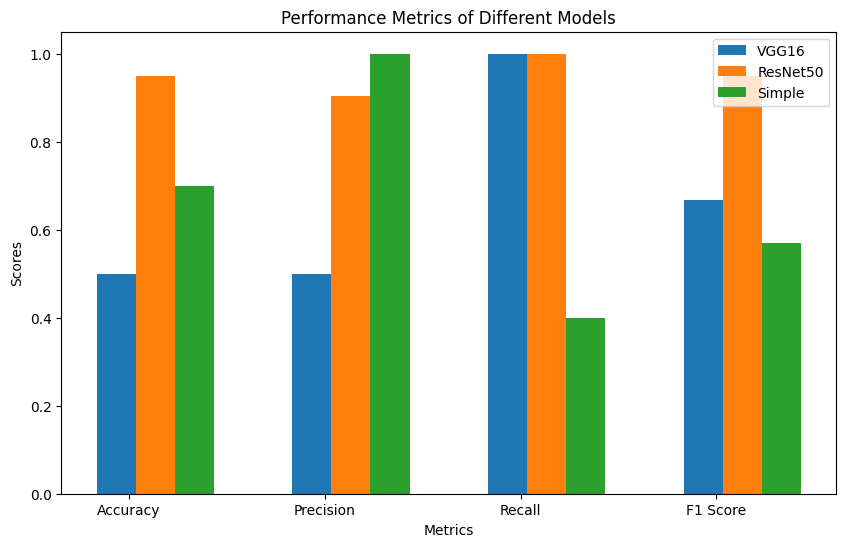

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
vgg16_metrics = [0.5000, 0.5000, 1.0000, 0.6667]
resnet50_metrics = [0.9500, 0.9036, 1.0, 0.95]
simple_metrics = [0.70, 1.0, 0.400, 0.57]

# Combine metrics into a list
all_metrics = [vgg16_metrics, resnet50_metrics, simple_metrics]

# Model names
model_names = ['VGG16', 'ResNet50', 'Simple']

# Number of metrics
n_metrics = len(metrics)

# Number of models
n_models = len(model_names)

# Positions of the bars on the x-axis
ind = np.arange(n_metrics)

# Width of a bar
width = 0.2

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each model
for i in range(n_models):
    ax.bar(ind + i * width, all_metrics[i], width, label=model_names[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Different Models')
ax.set_xticks(ind + width / n_models)
ax.set_xticklabels(metrics)
ax.legend()

# Display the plot
plt.show()


## 📦 Install Visualization Libraries
We install `seaborn` for aesthetically pleasing statistical plots  
and `mplcursors` for **interactive hover tooltips** in Matplotlib visualizations.


In [ ]:
pip install seaborn mplcursors


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.0 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20728 sha256=196c7d4ff60edbf7e8bee4bfa1dd6f9dcc844bb94909393635d0824376223099
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


## 🎨 Compare Model Performance (Seaborn + Interactive)
We enhance the previous performance comparison plot with:
- **Seaborn styling** for a cleaner look  
- **Custom colors** from the Husl palette  
- **Value annotations** above each bar  
- **Interactive hover tooltips** via `mplcursors`  

This allows both a polished presentation and interactive exploration of the scores.


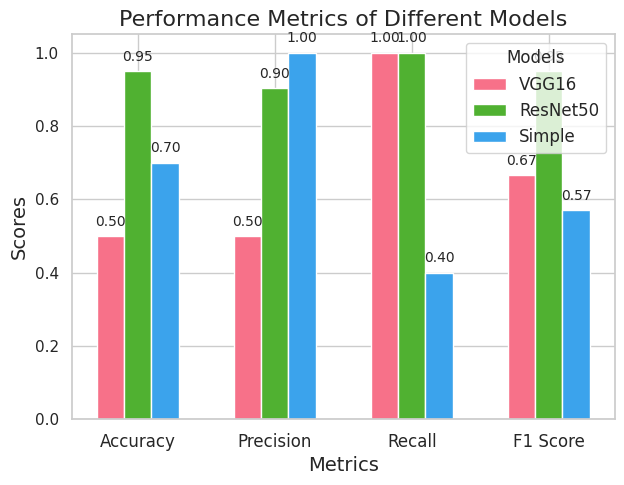

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mplcursors

# Metrics for each model
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
vgg16_metrics = [0.5000, 0.5000, 1.0000, 0.6667]
resnet50_metrics = [0.9500, 0.9036, 1.0, 0.95]
simple_metrics = [0.70, 1.0, 0.400, 0.57]

# Combine metrics into a list
all_metrics = [vgg16_metrics, resnet50_metrics, simple_metrics]

# Model names
model_names = ['VGG16', 'ResNet50', 'Simple']

# Number of metrics
n_metrics = len(metrics)

# Number of models
n_models = len(model_names)

# Positions of the bars on the x-axis
ind = np.arange(n_metrics)

# Width of a bar
width = 0.2

# Set the style
sns.set(style="whitegrid")

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

# Add bars for each model
colors = sns.color_palette("husl", n_models)  # Using Husl color palette from Seaborn
for i in range(n_models):
    ax.bar(ind + i * width, all_metrics[i], width, label=model_names[i], color=colors[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Performance Metrics of Different Models', fontsize=16)
ax.set_xticks(ind + width)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(title='Models', fontsize=12)

# Add value annotations on top of bars
for i in range(n_models):
    for j in range(n_metrics):
        ax.text(ind[j] + i * width, all_metrics[i][j] + 0.02, f'{all_metrics[i][j]:.2f}', ha='center', va='bottom', fontsize=10)

# Add interactivity using mplcursors
mplcursors.cursor(hover=True)

# Display the plot
plt.show()


## 📊 FCN Segmentation Metrics Comparison (Plotly)
We compare **Fully Convolutional Network (FCN)** segmentation metrics for the three CycleGAN variants:
- **Average IoU** (Intersection over Union)  
- **Average Per Pixel Accuracy**  
- **Average Per Class Accuracy**  

The plot is created using **Plotly** for interactivity, with grouped bars and hover tooltips to inspect each model’s score.


In [ ]:
import plotly.graph_objects as go

# Define the metrics and the corresponding values for each model
metrics = ['Average IoU', 'Average Per Pixel Accuracy', 'Average Per Class Accuracy']
simple_metrics = [0.3091, 0.9426, 0.4653]
vgg16_metrics = [0.6787, 0.9547, 0.8374]
resnet50_metrics = [0.2603, 0.8962, 0.4578]

# Create traces for each model
trace1 = go.Bar(
    x=metrics,
    y=simple_metrics,
    name='Simple CycleGAN',
    marker=dict(color='rgba(55, 83, 109, 0.7)')
)
trace2 = go.Bar(
    x=metrics,
    y=vgg16_metrics,
    name='VGG16 CycleGAN',
    marker=dict(color='rgba(26, 118, 255, 0.7)')
)
trace3 = go.Bar(
    x=metrics,
    y=resnet50_metrics,
    name='ResNet50 CycleGAN',
    marker=dict(color='rgba(50, 171, 96, 0.7)')
)

# Combine the traces into a single figure
data = [trace1, trace2, trace3]

# Define the layout of the plot
layout = go.Layout(
    title='FCN Metrics of Different CycleGAN Models',
    xaxis=dict(title='Metrics'),
    yaxis=dict(title='Scores'),
    barmode='group',
    plot_bgcolor='rgba(245, 245, 245, 1)',
    paper_bgcolor='rgba(245, 245, 245, 1)',
    hovermode='x'
)

# Create the figure and plot it
fig = go.Figure(data=data, layout=layout)
fig.show()
